In [10]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model
import time
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
import math
import pickle


In [11]:
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    try:
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {}

In [12]:
# generate data
def generate_data(nb_query=25, mean_doc_per_query=10):
    query = np.repeat(np.arange(nb_query)+1, np.ceil(np.abs(np.random.normal(mean_doc_per_query, size=nb_query, scale=0.15*mean_doc_per_query))+2).astype(np.int))
    doc_features = np.random.random((len(query), 10))
    doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

    # put data into pairs
    pair_id = []
    pair_query_id = []
    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        for pair_idx in combinations(query_idx, 2):
            pair_query_id.append(q)        
            pair_id.append(pair_idx)

    pair_id = np.array(pair_id)
    pair_query_id = np.array(pair_query_id)

    pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test = train_test_split(pair_id, pair_query_id, test_size=0.2, stratify=pair_query_id)
    
    return query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test


In [13]:
nb_query = 10
mean_doc_per_query = 5
query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test = generate_data(nb_query, mean_doc_per_query)


In [14]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))


class FactorisedRankNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        xi = inputs
        densei = self.dense[0](xi)
        for dense in self.dense[1:]:
            densei = dense(densei)
        oi = self.o(densei)
        return oi
    
    def build_graph(self):
        x = tf.keras.Input(shape=(10))
        return tf.keras.Model(inputs=x, outputs=self.call(x))
        

In [18]:
#
# Functions for training RankNet
#

# compute gradient and do backpropagation
def apply_gradient(optimizer, loss_object, model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss_value = loss_object(y, y_pred)
    
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return y_pred, loss_value


# compute loss on validation set
def compute_val_loss_efficient(loss_object, model):
    losses = []
    _xi = doc_features[pair_id_test[:,0]]
    _xj = doc_features[pair_id_test[:,1]]
    scorei = doc_scores[pair_id_test[:,0]]
    scorej = doc_scores[pair_id_test[:,1]]
    _pij = (scorei > scorej).astype(float)
    _pij[scorei==scorej] = 0.5
    _pij = _pij.reshape(-1,1)
    
    pij_pred = model([_xi, _xj])
    loss_value = loss_object(y_true=_pij, y_pred=pij_pred)
    losses.append(loss_value)
    
    return losses


# train for one epoch
def train_data_for_one_epoch_efficient(optimizer, loss_object, model, steps_total=None, apply_gradient=apply_gradient):
    losses = []
    
    pb_i = Progbar(steps_total)
    for (i,j) in pair_id_train:
        _xi = doc_features[[i]]
        _xj = doc_features[[j]]
        _pij = [[0.5]]
        if doc_scores[i] < doc_scores[j]:
            _pij = [[0]]
        elif doc_scores[i] > doc_scores[j]:
            _pij = [[1]]
        y_pred, loss_value = apply_gradient(optimizer, loss_object, model, [_xi, _xj], _pij)
        losses.append(loss_value)

        pb_i.add(1)
    
    return losses


In [19]:
def get_data(query_id, pair_id, pair_query_id):
    if type(query_id) is not np.ndarray:
        query_id = np.array([query_id]).ravel()
    _ind = np.hstack([np.where(query==i) for i in query_id]).ravel()

    q_unique, q_index, q_cnt  = np.unique(query, return_index=True, return_counts=True)
    doc_cnt = q_cnt[np.searchsorted(q_unique, query_id)].sum()
    x = doc_features[_ind]
    score = doc_scores[_ind]
    
    mask = np.zeros((doc_cnt, doc_cnt), dtype=np.float32)
    _, new_q_index = np.unique(query[_ind], return_index=True)
    _pair_id = np.vstack([pair_id[np.where(pair_query_id==i)] - q_index[q_unique==i] + new_q_index[query_id==i] for i in query_id])
    mask[_pair_id[:,0], _pair_id[:,1]] = 1

    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(score, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32), tf.convert_to_tensor(doc_cnt, dtype=tf.float32)


def apply_gradient_factorised(optimizer, model, x, score, mask, doc_cnt):
    with tf.GradientTape() as tape:
        oi = model(x)
    
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)
    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)
    
    doi_dwk = tape.jacobian(oi, model.trainable_weights)
    
    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k: 
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))
    
    # model could still be trained without calculating the loss below
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return oi, loss_value


def train_data_for_one_epoch_factorised(optimizer, model, batch_size=1, apply_gradient=apply_gradient_factorised):
    losses = []
    
    pb_i = Progbar(np.ceil(len(np.unique(query)) // batch_size), stateful_metrics=['loss'])
    _query = np.unique(query)
    np.random.shuffle(_query)
    for step, query_id in enumerate(_query):
        x, score, mask, doc_cnt= get_data(query_id, pair_id_train, pair_query_id_train)
        y_pred, loss_value = apply_gradient(optimizer, model, x, score, mask, doc_cnt)
        losses.append(loss_value)

        pb_i.add(1)
    return losses

def compute_val_loss_factorised(model):
    # compute cross entropy loss
    losses = []

    x, score, mask, doc_cnt = get_data(np.unique(query), pair_id_test, pair_query_id_test)
    oi = model(x)

    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.divide(tf.multiply(loss_value, doc_cnt), valid_pair_cnt)

    losses.append(loss_value)

    return losses


In [24]:
epoch_time_ranknet = load_obj('epoch_time_ranknet')
epoch_time_facranknet = load_obj('epoch_time_facranknet')
epoch_loss_ranknet = load_obj('epoch_loss_ranknet')
epoch_loss_facranknet = load_obj('epoch_loss_facranknet')

for mean_doc_per_query in [50]:
    print('================')
    print('================')
    print('================')
    print(mean_doc_per_query)
    print('================')
    print('================')
    print('================')
    
    epochs = 50
    nb_query = 25

    epoch_time_ranknet[mean_doc_per_query] = []
    epoch_time_facranknet[mean_doc_per_query] = []
    epoch_loss_ranknet[mean_doc_per_query] = {'trainloss':[], 'testloss':[]}
    epoch_loss_facranknet[mean_doc_per_query] = {'trainloss':[], 'testloss':[]}

    # generate data
    query, doc_features, doc_scores, pair_id, pair_id_train, pair_id_test, pair_query_id, pair_query_id_train, pair_query_id_test = generate_data(25, mean_doc_per_query)
    
    #
    # ranknet
    #
    ranknet = RankNet()

    loss_object = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    loss_train_history = []
    loss_val_history = []
    apply_gradient_graph = tf.function(apply_gradient)
    for epoch in range(epochs):
        time_start = time.perf_counter()
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train = train_data_for_one_epoch_efficient(optimizer, loss_object, ranknet, pair_id_train.shape[0], apply_gradient_graph)
        epoch_time_ranknet[mean_doc_per_query].append(time.perf_counter() - time_start)
        
        _loss_train = np.mean(losses_train)
        _loss_val = np.mean(compute_val_loss_efficient(loss_object, ranknet))
        loss_train_history.append(_loss_train)
        loss_val_history.append(_loss_val)
        print('Train loss: %.4f  Validation Loss: %.4f' % (_loss_train, _loss_val))
        epoch_loss_ranknet[mean_doc_per_query]['trainloss'].append(_loss_train)
        epoch_loss_ranknet[mean_doc_per_query]['testloss'].append(_loss_val)

    #
    # factorised ranknet
    #
    fac_ranknet = FactorisedRankNet()

    epochs = epochs*100
    optimizer = tf.keras.optimizers.Adam()
    loss_train_history = []
    loss_val_history = []
    apply_gradient_graph = tf.function(apply_gradient_factorised, experimental_relax_shapes=True)
    for epoch in range(epochs):
        time_start = time.perf_counter()
        print('Epoch %d/%d'%(epoch+1, epochs))
        losses_train = train_data_for_one_epoch_factorised(optimizer, fac_ranknet, apply_gradient=apply_gradient_graph)
        epoch_time_facranknet[mean_doc_per_query].append(time.perf_counter() - time_start)
        
        _loss_train = np.sum(losses_train)/pair_id_train.shape[0]
        _loss_val = np.mean(compute_val_loss_factorised(fac_ranknet))
        loss_train_history.append(_loss_train)
        loss_val_history.append(_loss_val)
        print('Train loss: %.4f  Validation Loss: %.4f' % (_loss_train, _loss_val))
        epoch_loss_facranknet[mean_doc_per_query]['trainloss'].append(_loss_train)
        epoch_loss_facranknet[mean_doc_per_query]['testloss'].append(_loss_val)
    
    save_obj(epoch_time_ranknet, 'epoch_time_ranknet')
    save_obj(epoch_loss_ranknet, 'epoch_loss_ranknet')
    save_obj(epoch_time_facranknet, 'epoch_time_facranknet')
    save_obj(epoch_loss_facranknet, 'epoch_loss_facranknet')


50
Epoch 1/50
26191/26191 [==============================] - 11s 427us/step
Train loss: 0.6862  Validation Loss: 0.6807
Epoch 2/50
26191/26191 [==============================] - 11s 419us/step
Train loss: 0.6720  Validation Loss: 0.6709
Epoch 3/50
26191/26191 [==============================] - 12s 449us/step
Train loss: 0.6613  Validation Loss: 0.6601
Epoch 4/50
26191/26191 [==============================] - 13s 512us/step
Train loss: 0.6526  Validation Loss: 0.6509
Epoch 5/50
26191/26191 [==============================] - 12s 448us/step
Train loss: 0.6444  Validation Loss: 0.6411
Epoch 6/50
26191/26191 [==============================] - 11s 408us/step
Train loss: 0.6361  Validation Loss: 0.6319
Epoch 7/50
26191/26191 [==============================] - 10s 401us/step
Train loss: 0.6274  Validation Loss: 0.6271
Epoch 8/50
26191/26191 [==============================] - 12s 469us/step
Train loss: 0.6218  Validation Loss: 0.6237
Epoch 9/50
26191/26191 [==============================] - 13s

25/25 [==============================] - 0s 2ms/step
Train loss: 0.6877  Validation Loss: 0.6886
Epoch 22/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6873  Validation Loss: 0.6882
Epoch 23/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6871  Validation Loss: 0.6880
Epoch 24/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6869  Validation Loss: 0.6877
Epoch 25/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6864  Validation Loss: 0.6874
Epoch 26/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6863  Validation Loss: 0.6872
Epoch 27/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6859  Validation Loss: 0.6869
Epoch 28/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6856  Validation Loss: 0.6866
Epoch 29/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6850  Validation Loss: 0.6863
Epoch 30/5000
2

Epoch 95/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6611  Validation Loss: 0.6657
Epoch 96/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6602  Validation Loss: 0.6649
Epoch 97/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6600  Validation Loss: 0.6649
Epoch 98/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6599  Validation Loss: 0.6645
Epoch 99/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6592  Validation Loss: 0.6645
Epoch 100/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6589  Validation Loss: 0.6640
Epoch 101/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6591  Validation Loss: 0.6643
Epoch 102/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6589  Validation Loss: 0.6634
Epoch 103/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6586  Validation Loss: 0.66

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6456  Validation Loss: 0.6512
Epoch 169/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6451  Validation Loss: 0.6502
Epoch 170/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6447  Validation Loss: 0.6508
Epoch 171/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6442  Validation Loss: 0.6506
Epoch 172/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6445  Validation Loss: 0.6502
Epoch 173/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6438  Validation Loss: 0.6497
Epoch 174/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6438  Validation Loss: 0.6493
Epoch 175/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6438  Validation Loss: 0.6495
Epoch 176/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6433  Validation Loss: 0.6494
Epoch 1

25/25 [==============================] - 0s 2ms/step
Train loss: 0.6338  Validation Loss: 0.6405
Epoch 242/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6339  Validation Loss: 0.6402
Epoch 243/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6342  Validation Loss: 0.6406
Epoch 244/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6346  Validation Loss: 0.6421
Epoch 245/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6338  Validation Loss: 0.6410
Epoch 246/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6337  Validation Loss: 0.6411
Epoch 247/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6339  Validation Loss: 0.6397
Epoch 248/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6329  Validation Loss: 0.6404
Epoch 249/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6327  Validation Loss: 0.6402
Epoch 2

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6247  Validation Loss: 0.6336
Epoch 315/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6252  Validation Loss: 0.6331
Epoch 316/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6244  Validation Loss: 0.6328
Epoch 317/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6240  Validation Loss: 0.6326
Epoch 318/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6242  Validation Loss: 0.6326
Epoch 319/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6241  Validation Loss: 0.6322
Epoch 320/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6242  Validation Loss: 0.6316
Epoch 321/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6243  Validation Loss: 0.6320
Epoch 322/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6243  Validation Loss: 0.6325
Epoch 3

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6179  Validation Loss: 0.6259
Epoch 388/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6173  Validation Loss: 0.6259
Epoch 389/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6175  Validation Loss: 0.6261
Epoch 390/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6185  Validation Loss: 0.6261
Epoch 391/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6180  Validation Loss: 0.6262
Epoch 392/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6178  Validation Loss: 0.6254
Epoch 393/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6175  Validation Loss: 0.6269
Epoch 394/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6172  Validation Loss: 0.6253
Epoch 395/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6180  Validation Loss: 0.6264
Epoch 3

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6120  Validation Loss: 0.6209
Epoch 461/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6117  Validation Loss: 0.6211
Epoch 462/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6139  Validation Loss: 0.6253
Epoch 463/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6129  Validation Loss: 0.6220
Epoch 464/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6122  Validation Loss: 0.6207
Epoch 465/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6117  Validation Loss: 0.6210
Epoch 466/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6116  Validation Loss: 0.6209
Epoch 467/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.6117  Validation Loss: 0.6211
Epoch 468/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6116  Validation Loss: 0.6204
Epoch 4

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6084  Validation Loss: 0.6184
Epoch 534/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6090  Validation Loss: 0.6178
Epoch 535/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6091  Validation Loss: 0.6192
Epoch 536/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6087  Validation Loss: 0.6175
Epoch 537/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6081  Validation Loss: 0.6178
Epoch 538/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6083  Validation Loss: 0.6179
Epoch 539/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6082  Validation Loss: 0.6178
Epoch 540/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6076  Validation Loss: 0.6189
Epoch 541/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6086  Validation Loss: 0.6186
Epoch 5

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6068  Validation Loss: 0.6186
Epoch 607/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6072  Validation Loss: 0.6179
Epoch 608/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6065  Validation Loss: 0.6194
Epoch 609/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6075  Validation Loss: 0.6163
Epoch 610/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6059  Validation Loss: 0.6159
Epoch 611/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6057  Validation Loss: 0.6160
Epoch 612/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6057  Validation Loss: 0.6158
Epoch 613/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6059  Validation Loss: 0.6163
Epoch 614/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6061  Validation Loss: 0.6153
Epoch 6

25/25 [==============================] - 0s 2ms/step
Train loss: 0.6041  Validation Loss: 0.6151
Epoch 680/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6046  Validation Loss: 0.6137
Epoch 681/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6035  Validation Loss: 0.6146
Epoch 682/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6038  Validation Loss: 0.6141
Epoch 683/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6034  Validation Loss: 0.6139
Epoch 684/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6044  Validation Loss: 0.6141
Epoch 685/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6040  Validation Loss: 0.6147
Epoch 686/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6036  Validation Loss: 0.6143
Epoch 687/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6040  Validation Loss: 0.6143
Epoch 6

25/25 [==============================] - 0s 1ms/step
Train loss: 0.6012  Validation Loss: 0.6119
Epoch 753/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6011  Validation Loss: 0.6132
Epoch 754/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6017  Validation Loss: 0.6118
Epoch 755/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6019  Validation Loss: 0.6115
Epoch 756/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6018  Validation Loss: 0.6118
Epoch 757/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6016  Validation Loss: 0.6119
Epoch 758/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6017  Validation Loss: 0.6121
Epoch 759/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6017  Validation Loss: 0.6115
Epoch 760/5000
25/25 [==============================] - 0s 3ms/step
Train loss: 0.6003  Validation Loss: 0.6115
Epoch 7

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5983  Validation Loss: 0.6102
Epoch 826/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.6000  Validation Loss: 0.6109
Epoch 827/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5993  Validation Loss: 0.6103
Epoch 828/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5982  Validation Loss: 0.6095
Epoch 829/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5995  Validation Loss: 0.6100
Epoch 830/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5994  Validation Loss: 0.6110
Epoch 831/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5998  Validation Loss: 0.6098
Epoch 832/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5993  Validation Loss: 0.6100
Epoch 833/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5988  Validation Loss: 0.6095
Epoch 8

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5971  Validation Loss: 0.6075
Epoch 899/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5985  Validation Loss: 0.6104
Epoch 900/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5980  Validation Loss: 0.6074
Epoch 901/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5981  Validation Loss: 0.6095
Epoch 902/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5982  Validation Loss: 0.6081
Epoch 903/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5971  Validation Loss: 0.6071
Epoch 904/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5976  Validation Loss: 0.6072
Epoch 905/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5965  Validation Loss: 0.6078
Epoch 906/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5967  Validation Loss: 0.6074
Epoch 9

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5964  Validation Loss: 0.6058
Epoch 972/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5959  Validation Loss: 0.6059
Epoch 973/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5955  Validation Loss: 0.6058
Epoch 974/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5947  Validation Loss: 0.6055
Epoch 975/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5951  Validation Loss: 0.6068
Epoch 976/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5965  Validation Loss: 0.6061
Epoch 977/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5954  Validation Loss: 0.6052
Epoch 978/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5947  Validation Loss: 0.6062
Epoch 979/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5959  Validation Loss: 0.6066
Epoch 9

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5946  Validation Loss: 0.6050
Epoch 1045/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5930  Validation Loss: 0.6031
Epoch 1046/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5928  Validation Loss: 0.6047
Epoch 1047/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5941  Validation Loss: 0.6038
Epoch 1048/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5946  Validation Loss: 0.6034
Epoch 1049/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5934  Validation Loss: 0.6052
Epoch 1050/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5945  Validation Loss: 0.6043
Epoch 1051/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5939  Validation Loss: 0.6044
Epoch 1052/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5936  Validation Loss: 0.6042

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5925  Validation Loss: 0.6031
Epoch 1118/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5941  Validation Loss: 0.6026
Epoch 1119/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5918  Validation Loss: 0.6025
Epoch 1120/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5911  Validation Loss: 0.6022
Epoch 1121/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5917  Validation Loss: 0.6030
Epoch 1122/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5911  Validation Loss: 0.6025
Epoch 1123/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5918  Validation Loss: 0.6020
Epoch 1124/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5916  Validation Loss: 0.6020
Epoch 1125/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5908  Validation Loss: 0.6021

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5908  Validation Loss: 0.6014
Epoch 1191/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5902  Validation Loss: 0.6016
Epoch 1192/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5900  Validation Loss: 0.6022
Epoch 1193/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5908  Validation Loss: 0.6012
Epoch 1194/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5908  Validation Loss: 0.6011
Epoch 1195/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5893  Validation Loss: 0.6013
Epoch 1196/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5921  Validation Loss: 0.6049
Epoch 1197/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5911  Validation Loss: 0.6010
Epoch 1198/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5904  Validation Loss: 0.6033

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5883  Validation Loss: 0.6013
Epoch 1264/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5891  Validation Loss: 0.6017
Epoch 1265/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5889  Validation Loss: 0.6011
Epoch 1266/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5913  Validation Loss: 0.6019
Epoch 1267/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5887  Validation Loss: 0.5998
Epoch 1268/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5900  Validation Loss: 0.6017
Epoch 1269/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5885  Validation Loss: 0.6001
Epoch 1270/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5891  Validation Loss: 0.6017
Epoch 1271/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5889  Validation Loss: 0.6003

25/25 [==============================] - 0s 2ms/step
Train loss: 0.5873  Validation Loss: 0.5989
Epoch 1337/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5861  Validation Loss: 0.5988
Epoch 1338/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5870  Validation Loss: 0.6009
Epoch 1339/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5891  Validation Loss: 0.6003
Epoch 1340/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5878  Validation Loss: 0.5992
Epoch 1341/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5893  Validation Loss: 0.6020
Epoch 1342/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5869  Validation Loss: 0.5986
Epoch 1343/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5870  Validation Loss: 0.6004
Epoch 1344/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5874  Validation Loss: 0.5983

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5865  Validation Loss: 0.5968
Epoch 1410/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5854  Validation Loss: 0.5970
Epoch 1411/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5848  Validation Loss: 0.5974
Epoch 1412/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5860  Validation Loss: 0.5975
Epoch 1413/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5851  Validation Loss: 0.5994
Epoch 1414/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5845  Validation Loss: 0.5966
Epoch 1415/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5859  Validation Loss: 0.5988
Epoch 1416/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5868  Validation Loss: 0.5976
Epoch 1417/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5852  Validation Loss: 0.5968

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5835  Validation Loss: 0.5952
Epoch 1483/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5837  Validation Loss: 0.5993
Epoch 1484/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5850  Validation Loss: 0.5960
Epoch 1485/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5833  Validation Loss: 0.5976
Epoch 1486/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5846  Validation Loss: 0.5966
Epoch 1487/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5837  Validation Loss: 0.5956
Epoch 1488/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5842  Validation Loss: 0.5955
Epoch 1489/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5842  Validation Loss: 0.5991
Epoch 1490/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5851  Validation Loss: 0.5967

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5816  Validation Loss: 0.5928
Epoch 1556/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5822  Validation Loss: 0.5949
Epoch 1557/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5836  Validation Loss: 0.5946
Epoch 1558/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5807  Validation Loss: 0.5948
Epoch 1559/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5825  Validation Loss: 0.5929
Epoch 1560/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5827  Validation Loss: 0.5920
Epoch 1561/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5805  Validation Loss: 0.5939
Epoch 1562/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5813  Validation Loss: 0.5953
Epoch 1563/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5813  Validation Loss: 0.5920

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5780  Validation Loss: 0.5894
Epoch 1629/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5784  Validation Loss: 0.5890
Epoch 1630/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5790  Validation Loss: 0.5899
Epoch 1631/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5792  Validation Loss: 0.5901
Epoch 1632/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5784  Validation Loss: 0.5898
Epoch 1633/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5777  Validation Loss: 0.5911
Epoch 1634/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5792  Validation Loss: 0.5901
Epoch 1635/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5787  Validation Loss: 0.5893
Epoch 1636/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5793  Validation Loss: 0.5889

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5772  Validation Loss: 0.5895
Epoch 1702/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5793  Validation Loss: 0.5887
Epoch 1703/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5769  Validation Loss: 0.5869
Epoch 1704/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5787  Validation Loss: 0.5890
Epoch 1705/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5759  Validation Loss: 0.5868
Epoch 1706/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5765  Validation Loss: 0.5870
Epoch 1707/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5766  Validation Loss: 0.5874
Epoch 1708/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5763  Validation Loss: 0.5866
Epoch 1709/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5757  Validation Loss: 0.5865

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5745  Validation Loss: 0.5849
Epoch 1775/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5752  Validation Loss: 0.5893
Epoch 1776/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5747  Validation Loss: 0.5851
Epoch 1777/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5748  Validation Loss: 0.5847
Epoch 1778/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5731  Validation Loss: 0.5838
Epoch 1779/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5733  Validation Loss: 0.5852
Epoch 1780/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5748  Validation Loss: 0.5839
Epoch 1781/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5743  Validation Loss: 0.5843
Epoch 1782/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5742  Validation Loss: 0.5833

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5707  Validation Loss: 0.5833
Epoch 1848/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5714  Validation Loss: 0.5820
Epoch 1849/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5703  Validation Loss: 0.5815
Epoch 1850/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5739  Validation Loss: 0.5842
Epoch 1851/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5753  Validation Loss: 0.5818
Epoch 1852/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5715  Validation Loss: 0.5817
Epoch 1853/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5707  Validation Loss: 0.5819
Epoch 1854/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5706  Validation Loss: 0.5812
Epoch 1855/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5716  Validation Loss: 0.5841

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5682  Validation Loss: 0.5791
Epoch 1921/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5683  Validation Loss: 0.5796
Epoch 1922/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5675  Validation Loss: 0.5811
Epoch 1923/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5683  Validation Loss: 0.5797
Epoch 1924/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5676  Validation Loss: 0.5813
Epoch 1925/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5683  Validation Loss: 0.5801
Epoch 1926/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5671  Validation Loss: 0.5799
Epoch 1927/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5670  Validation Loss: 0.5812
Epoch 1928/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5688  Validation Loss: 0.5824

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5663  Validation Loss: 0.5781
Epoch 1994/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5662  Validation Loss: 0.5771
Epoch 1995/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5653  Validation Loss: 0.5794
Epoch 1996/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5658  Validation Loss: 0.5789
Epoch 1997/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5662  Validation Loss: 0.5775
Epoch 1998/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5651  Validation Loss: 0.5785
Epoch 1999/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5638  Validation Loss: 0.5775
Epoch 2000/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5649  Validation Loss: 0.5786
Epoch 2001/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5662  Validation Loss: 0.5783

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5627  Validation Loss: 0.5767
Epoch 2067/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5640  Validation Loss: 0.5755
Epoch 2068/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5634  Validation Loss: 0.5782
Epoch 2069/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5631  Validation Loss: 0.5763
Epoch 2070/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5635  Validation Loss: 0.5757
Epoch 2071/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5639  Validation Loss: 0.5799
Epoch 2072/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5635  Validation Loss: 0.5756
Epoch 2073/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5637  Validation Loss: 0.5776
Epoch 2074/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5646  Validation Loss: 0.5758

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5620  Validation Loss: 0.5751
Epoch 2140/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5629  Validation Loss: 0.5748
Epoch 2141/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5620  Validation Loss: 0.5749
Epoch 2142/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5612  Validation Loss: 0.5751
Epoch 2143/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5633  Validation Loss: 0.5751
Epoch 2144/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5632  Validation Loss: 0.5745
Epoch 2145/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5615  Validation Loss: 0.5742
Epoch 2146/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5619  Validation Loss: 0.5754
Epoch 2147/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5620  Validation Loss: 0.5756

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5602  Validation Loss: 0.5758
Epoch 2213/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5616  Validation Loss: 0.5731
Epoch 2214/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5592  Validation Loss: 0.5769
Epoch 2215/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5624  Validation Loss: 0.5738
Epoch 2216/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5603  Validation Loss: 0.5737
Epoch 2217/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5598  Validation Loss: 0.5733
Epoch 2218/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5598  Validation Loss: 0.5731
Epoch 2219/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5591  Validation Loss: 0.5732
Epoch 2220/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5603  Validation Loss: 0.5733

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5590  Validation Loss: 0.5739
Epoch 2286/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5588  Validation Loss: 0.5720
Epoch 2287/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5590  Validation Loss: 0.5714
Epoch 2288/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5588  Validation Loss: 0.5713
Epoch 2289/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5578  Validation Loss: 0.5707
Epoch 2290/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5577  Validation Loss: 0.5714
Epoch 2291/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5589  Validation Loss: 0.5711
Epoch 2292/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5590  Validation Loss: 0.5726
Epoch 2293/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5594  Validation Loss: 0.5740

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5565  Validation Loss: 0.5696
Epoch 2359/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5567  Validation Loss: 0.5696
Epoch 2360/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5569  Validation Loss: 0.5690
Epoch 2361/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5567  Validation Loss: 0.5688
Epoch 2362/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5572  Validation Loss: 0.5730
Epoch 2363/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5569  Validation Loss: 0.5700
Epoch 2364/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5562  Validation Loss: 0.5722
Epoch 2365/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5577  Validation Loss: 0.5692
Epoch 2366/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5562  Validation Loss: 0.5694

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5574  Validation Loss: 0.5684
Epoch 2432/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5544  Validation Loss: 0.5693
Epoch 2433/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5544  Validation Loss: 0.5683
Epoch 2434/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5563  Validation Loss: 0.5690
Epoch 2435/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5556  Validation Loss: 0.5700
Epoch 2436/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5545  Validation Loss: 0.5684
Epoch 2437/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5548  Validation Loss: 0.5690
Epoch 2438/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5559  Validation Loss: 0.5685
Epoch 2439/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5545  Validation Loss: 0.5678

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5541  Validation Loss: 0.5677
Epoch 2505/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5532  Validation Loss: 0.5683
Epoch 2506/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5537  Validation Loss: 0.5678
Epoch 2507/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5537  Validation Loss: 0.5687
Epoch 2508/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5535  Validation Loss: 0.5665
Epoch 2509/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5534  Validation Loss: 0.5687
Epoch 2510/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5536  Validation Loss: 0.5681
Epoch 2511/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5555  Validation Loss: 0.5676
Epoch 2512/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5528  Validation Loss: 0.5685

25/25 [==============================] - 0s 2ms/step
Train loss: 0.5538  Validation Loss: 0.5686
Epoch 2578/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5544  Validation Loss: 0.5668
Epoch 2579/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5528  Validation Loss: 0.5675
Epoch 2580/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5535  Validation Loss: 0.5663
Epoch 2581/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5532  Validation Loss: 0.5667
Epoch 2582/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5536  Validation Loss: 0.5668
Epoch 2583/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5544  Validation Loss: 0.5712
Epoch 2584/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5526  Validation Loss: 0.5665
Epoch 2585/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5530  Validation Loss: 0.5678

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5507  Validation Loss: 0.5659
Epoch 2651/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5529  Validation Loss: 0.5674
Epoch 2652/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5541  Validation Loss: 0.5683
Epoch 2653/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5514  Validation Loss: 0.5679
Epoch 2654/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5540  Validation Loss: 0.5678
Epoch 2655/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5550  Validation Loss: 0.5711
Epoch 2656/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5536  Validation Loss: 0.5658
Epoch 2657/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5514  Validation Loss: 0.5656
Epoch 2658/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5541  Validation Loss: 0.5653

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5526  Validation Loss: 0.5655
Epoch 2724/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5516  Validation Loss: 0.5657
Epoch 2725/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5524  Validation Loss: 0.5662
Epoch 2726/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5512  Validation Loss: 0.5656
Epoch 2727/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5524  Validation Loss: 0.5672
Epoch 2728/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5518  Validation Loss: 0.5658
Epoch 2729/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5516  Validation Loss: 0.5662
Epoch 2730/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5529  Validation Loss: 0.5673
Epoch 2731/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5520  Validation Loss: 0.5676

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5501  Validation Loss: 0.5662
Epoch 2797/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5506  Validation Loss: 0.5661
Epoch 2798/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5516  Validation Loss: 0.5656
Epoch 2799/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5509  Validation Loss: 0.5653
Epoch 2800/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5535  Validation Loss: 0.5645
Epoch 2801/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5495  Validation Loss: 0.5666
Epoch 2802/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5513  Validation Loss: 0.5651
Epoch 2803/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5512  Validation Loss: 0.5664
Epoch 2804/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5520  Validation Loss: 0.5644

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5503  Validation Loss: 0.5650
Epoch 2870/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5489  Validation Loss: 0.5639
Epoch 2871/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5503  Validation Loss: 0.5678
Epoch 2872/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5509  Validation Loss: 0.5659
Epoch 2873/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5499  Validation Loss: 0.5668
Epoch 2874/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5492  Validation Loss: 0.5634
Epoch 2875/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5498  Validation Loss: 0.5638
Epoch 2876/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5504  Validation Loss: 0.5633
Epoch 2877/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5491  Validation Loss: 0.5640

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5495  Validation Loss: 0.5643
Epoch 2943/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5524  Validation Loss: 0.5632
Epoch 2944/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5489  Validation Loss: 0.5636
Epoch 2945/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5495  Validation Loss: 0.5630
Epoch 2946/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5484  Validation Loss: 0.5667
Epoch 2947/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5494  Validation Loss: 0.5628
Epoch 2948/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5487  Validation Loss: 0.5644
Epoch 2949/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5489  Validation Loss: 0.5635
Epoch 2950/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5509  Validation Loss: 0.5657

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5506  Validation Loss: 0.5696
Epoch 3016/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5499  Validation Loss: 0.5665
Epoch 3017/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5481  Validation Loss: 0.5635
Epoch 3018/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5490  Validation Loss: 0.5659
Epoch 3019/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5505  Validation Loss: 0.5641
Epoch 3020/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5484  Validation Loss: 0.5640
Epoch 3021/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5482  Validation Loss: 0.5673
Epoch 3022/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5495  Validation Loss: 0.5651
Epoch 3023/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5482  Validation Loss: 0.5645

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5466  Validation Loss: 0.5635
Epoch 3089/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5502  Validation Loss: 0.5645
Epoch 3090/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5497  Validation Loss: 0.5621
Epoch 3091/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5476  Validation Loss: 0.5622
Epoch 3092/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5474  Validation Loss: 0.5639
Epoch 3093/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5489  Validation Loss: 0.5635
Epoch 3094/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5487  Validation Loss: 0.5658
Epoch 3095/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5480  Validation Loss: 0.5653
Epoch 3096/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5506  Validation Loss: 0.5630

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5462  Validation Loss: 0.5626
Epoch 3162/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5476  Validation Loss: 0.5635
Epoch 3163/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5481  Validation Loss: 0.5627
Epoch 3164/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5468  Validation Loss: 0.5630
Epoch 3165/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5457  Validation Loss: 0.5640
Epoch 3166/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5464  Validation Loss: 0.5623
Epoch 3167/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5465  Validation Loss: 0.5626
Epoch 3168/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5471  Validation Loss: 0.5657
Epoch 3169/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5474  Validation Loss: 0.5619

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5475  Validation Loss: 0.5673
Epoch 3235/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5472  Validation Loss: 0.5641
Epoch 3236/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5457  Validation Loss: 0.5626
Epoch 3237/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5463  Validation Loss: 0.5616
Epoch 3238/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5464  Validation Loss: 0.5617
Epoch 3239/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5462  Validation Loss: 0.5623
Epoch 3240/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5465  Validation Loss: 0.5615
Epoch 3241/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5485  Validation Loss: 0.5670
Epoch 3242/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5479  Validation Loss: 0.5667

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5462  Validation Loss: 0.5623
Epoch 3308/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5463  Validation Loss: 0.5613
Epoch 3309/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5485  Validation Loss: 0.5629
Epoch 3310/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5463  Validation Loss: 0.5629
Epoch 3311/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5471  Validation Loss: 0.5618
Epoch 3312/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5472  Validation Loss: 0.5651
Epoch 3313/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5474  Validation Loss: 0.5615
Epoch 3314/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5457  Validation Loss: 0.5615
Epoch 3315/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5449  Validation Loss: 0.5609

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5445  Validation Loss: 0.5632
Epoch 3381/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5456  Validation Loss: 0.5627
Epoch 3382/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5468  Validation Loss: 0.5612
Epoch 3383/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5444  Validation Loss: 0.5612
Epoch 3384/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5457  Validation Loss: 0.5628
Epoch 3385/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5460  Validation Loss: 0.5615
Epoch 3386/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5464  Validation Loss: 0.5617
Epoch 3387/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5454  Validation Loss: 0.5615
Epoch 3388/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5461  Validation Loss: 0.5617

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5450  Validation Loss: 0.5620
Epoch 3454/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5455  Validation Loss: 0.5613
Epoch 3455/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5441  Validation Loss: 0.5619
Epoch 3456/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5454  Validation Loss: 0.5608
Epoch 3457/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5442  Validation Loss: 0.5606
Epoch 3458/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5457  Validation Loss: 0.5612
Epoch 3459/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5452  Validation Loss: 0.5606
Epoch 3460/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5440  Validation Loss: 0.5614
Epoch 3461/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5444  Validation Loss: 0.5614

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5440  Validation Loss: 0.5603
Epoch 3527/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5446  Validation Loss: 0.5619
Epoch 3528/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5456  Validation Loss: 0.5599
Epoch 3529/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5447  Validation Loss: 0.5643
Epoch 3530/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5458  Validation Loss: 0.5633
Epoch 3531/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5476  Validation Loss: 0.5621
Epoch 3532/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5443  Validation Loss: 0.5615
Epoch 3533/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5443  Validation Loss: 0.5601
Epoch 3534/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5449  Validation Loss: 0.5618

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5439  Validation Loss: 0.5610
Epoch 3600/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5448  Validation Loss: 0.5599
Epoch 3601/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5443  Validation Loss: 0.5629
Epoch 3602/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5431  Validation Loss: 0.5598
Epoch 3603/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5464  Validation Loss: 0.5622
Epoch 3604/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5473  Validation Loss: 0.5613
Epoch 3605/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5424  Validation Loss: 0.5624
Epoch 3606/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5444  Validation Loss: 0.5599
Epoch 3607/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5432  Validation Loss: 0.5621

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5457  Validation Loss: 0.5674
Epoch 3673/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5617
Epoch 3674/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5445  Validation Loss: 0.5609
Epoch 3675/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5432  Validation Loss: 0.5600
Epoch 3676/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5453  Validation Loss: 0.5618
Epoch 3677/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5443  Validation Loss: 0.5603
Epoch 3678/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5437  Validation Loss: 0.5599
Epoch 3679/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5429  Validation Loss: 0.5594
Epoch 3680/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5446  Validation Loss: 0.5599

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5441  Validation Loss: 0.5618
Epoch 3746/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5432  Validation Loss: 0.5643
Epoch 3747/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5445  Validation Loss: 0.5610
Epoch 3748/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5447  Validation Loss: 0.5639
Epoch 3749/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5435  Validation Loss: 0.5590
Epoch 3750/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5598
Epoch 3751/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5435  Validation Loss: 0.5605
Epoch 3752/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5600
Epoch 3753/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5594

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5602
Epoch 3819/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5448  Validation Loss: 0.5598
Epoch 3820/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5449  Validation Loss: 0.5603
Epoch 3821/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5431  Validation Loss: 0.5617
Epoch 3822/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5446  Validation Loss: 0.5592
Epoch 3823/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5431  Validation Loss: 0.5639
Epoch 3824/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5440  Validation Loss: 0.5631
Epoch 3825/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5434  Validation Loss: 0.5604
Epoch 3826/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5436  Validation Loss: 0.5591

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5434  Validation Loss: 0.5598
Epoch 3892/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5601
Epoch 3893/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5609
Epoch 3894/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5443  Validation Loss: 0.5590
Epoch 3895/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5428  Validation Loss: 0.5588
Epoch 3896/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5434  Validation Loss: 0.5627
Epoch 3897/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5435  Validation Loss: 0.5592
Epoch 3898/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5438  Validation Loss: 0.5627
Epoch 3899/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5420  Validation Loss: 0.5595

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5422  Validation Loss: 0.5598
Epoch 3965/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5432  Validation Loss: 0.5683
Epoch 3966/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5594
Epoch 3967/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5590
Epoch 3968/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5448  Validation Loss: 0.5602
Epoch 3969/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5415  Validation Loss: 0.5598
Epoch 3970/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5426  Validation Loss: 0.5598
Epoch 3971/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5411  Validation Loss: 0.5655
Epoch 3972/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5466  Validation Loss: 0.5664

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5427  Validation Loss: 0.5618
Epoch 4038/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5429  Validation Loss: 0.5584
Epoch 4039/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5416  Validation Loss: 0.5593
Epoch 4040/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5417  Validation Loss: 0.5583
Epoch 4041/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5427  Validation Loss: 0.5620
Epoch 4042/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5588
Epoch 4043/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5420  Validation Loss: 0.5589
Epoch 4044/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5422  Validation Loss: 0.5615
Epoch 4045/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5407  Validation Loss: 0.5592

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5445  Validation Loss: 0.5596
Epoch 4111/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5415  Validation Loss: 0.5587
Epoch 4112/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5428  Validation Loss: 0.5595
Epoch 4113/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5413  Validation Loss: 0.5655
Epoch 4114/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5432  Validation Loss: 0.5597
Epoch 4115/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5412  Validation Loss: 0.5635
Epoch 4116/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5439  Validation Loss: 0.5618
Epoch 4117/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5451  Validation Loss: 0.5599
Epoch 4118/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5609

25/25 [==============================] - 0s 2ms/step
Train loss: 0.5408  Validation Loss: 0.5588
Epoch 4184/5000
25/25 [==============================] - 0s 3ms/step
Train loss: 0.5406  Validation Loss: 0.5580
Epoch 4185/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5421  Validation Loss: 0.5584
Epoch 4186/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5399  Validation Loss: 0.5604
Epoch 4187/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5446  Validation Loss: 0.5600
Epoch 4188/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5416  Validation Loss: 0.5608
Epoch 4189/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5593
Epoch 4190/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5430  Validation Loss: 0.5620
Epoch 4191/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5415  Validation Loss: 0.5603

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5450  Validation Loss: 0.5603
Epoch 4257/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5440  Validation Loss: 0.5602
Epoch 4258/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5433  Validation Loss: 0.5595
Epoch 4259/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5404  Validation Loss: 0.5589
Epoch 4260/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5431  Validation Loss: 0.5588
Epoch 4261/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5423  Validation Loss: 0.5587
Epoch 4262/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5419  Validation Loss: 0.5595
Epoch 4263/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5420  Validation Loss: 0.5590
Epoch 4264/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5398  Validation Loss: 0.5605

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5604
Epoch 4330/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5409  Validation Loss: 0.5584
Epoch 4331/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5399  Validation Loss: 0.5581
Epoch 4332/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5416  Validation Loss: 0.5594
Epoch 4333/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5396  Validation Loss: 0.5597
Epoch 4334/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5396  Validation Loss: 0.5610
Epoch 4335/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5413  Validation Loss: 0.5637
Epoch 4336/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5406  Validation Loss: 0.5601
Epoch 4337/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5418  Validation Loss: 0.5592

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5599
Epoch 4403/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5411  Validation Loss: 0.5600
Epoch 4404/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5403  Validation Loss: 0.5597
Epoch 4405/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5410  Validation Loss: 0.5590
Epoch 4406/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5423  Validation Loss: 0.5590
Epoch 4407/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5400  Validation Loss: 0.5607
Epoch 4408/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5400  Validation Loss: 0.5584
Epoch 4409/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5404  Validation Loss: 0.5637
Epoch 4410/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5410  Validation Loss: 0.5603

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5436  Validation Loss: 0.5611
Epoch 4476/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5427  Validation Loss: 0.5616
Epoch 4477/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5402  Validation Loss: 0.5598
Epoch 4478/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5419  Validation Loss: 0.5591
Epoch 4479/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5428  Validation Loss: 0.5603
Epoch 4480/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5395  Validation Loss: 0.5624
Epoch 4481/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5407  Validation Loss: 0.5578
Epoch 4482/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5422  Validation Loss: 0.5583
Epoch 4483/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5404  Validation Loss: 0.5586

25/25 [==============================] - 0s 2ms/step
Train loss: 0.5411  Validation Loss: 0.5589
Epoch 4549/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5400  Validation Loss: 0.5609
Epoch 4550/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5403  Validation Loss: 0.5582
Epoch 4551/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5402  Validation Loss: 0.5576
Epoch 4552/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5396  Validation Loss: 0.5595
Epoch 4553/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5397  Validation Loss: 0.5580
Epoch 4554/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5417  Validation Loss: 0.5588
Epoch 4555/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5417  Validation Loss: 0.5578
Epoch 4556/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5426  Validation Loss: 0.5569

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5400  Validation Loss: 0.5579
Epoch 4622/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5397  Validation Loss: 0.5578
Epoch 4623/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5395  Validation Loss: 0.5571
Epoch 4624/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5398  Validation Loss: 0.5573
Epoch 4625/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5396  Validation Loss: 0.5591
Epoch 4626/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5421  Validation Loss: 0.5595
Epoch 4627/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5572
Epoch 4628/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5393  Validation Loss: 0.5577
Epoch 4629/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5401  Validation Loss: 0.5629

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5393  Validation Loss: 0.5571
Epoch 4695/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5390  Validation Loss: 0.5609
Epoch 4696/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5412  Validation Loss: 0.5589
Epoch 4697/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5410  Validation Loss: 0.5595
Epoch 4698/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5405  Validation Loss: 0.5571
Epoch 4699/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5390  Validation Loss: 0.5592
Epoch 4700/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5605
Epoch 4701/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5414  Validation Loss: 0.5578
Epoch 4702/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5405  Validation Loss: 0.5578

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5388  Validation Loss: 0.5563
Epoch 4768/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5402  Validation Loss: 0.5607
Epoch 4769/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5401  Validation Loss: 0.5585
Epoch 4770/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5397  Validation Loss: 0.5583
Epoch 4771/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5408  Validation Loss: 0.5569
Epoch 4772/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5398  Validation Loss: 0.5585
Epoch 4773/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5399  Validation Loss: 0.5566
Epoch 4774/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5405  Validation Loss: 0.5601
Epoch 4775/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5392  Validation Loss: 0.5660

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5403  Validation Loss: 0.5579
Epoch 4841/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5387  Validation Loss: 0.5573
Epoch 4842/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5409  Validation Loss: 0.5600
Epoch 4843/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5410  Validation Loss: 0.5594
Epoch 4844/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5393  Validation Loss: 0.5589
Epoch 4845/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5418  Validation Loss: 0.5565
Epoch 4846/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5399  Validation Loss: 0.5608
Epoch 4847/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5409  Validation Loss: 0.5575
Epoch 4848/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5409  Validation Loss: 0.5577

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5406  Validation Loss: 0.5577
Epoch 4914/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5394  Validation Loss: 0.5567
Epoch 4915/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5407  Validation Loss: 0.5577
Epoch 4916/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5425  Validation Loss: 0.5585
Epoch 4917/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5425  Validation Loss: 0.5580
Epoch 4918/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5423  Validation Loss: 0.5585
Epoch 4919/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5398  Validation Loss: 0.5605
Epoch 4920/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5398  Validation Loss: 0.5573
Epoch 4921/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5392  Validation Loss: 0.5574

25/25 [==============================] - 0s 1ms/step
Train loss: 0.5384  Validation Loss: 0.5562
Epoch 4987/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5393  Validation Loss: 0.5566
Epoch 4988/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5383  Validation Loss: 0.5573
Epoch 4989/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5392  Validation Loss: 0.5566
Epoch 4990/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5411  Validation Loss: 0.5616
Epoch 4991/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5408  Validation Loss: 0.5566
Epoch 4992/5000
25/25 [==============================] - 0s 2ms/step
Train loss: 0.5393  Validation Loss: 0.5591
Epoch 4993/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5389  Validation Loss: 0.5600
Epoch 4994/5000
25/25 [==============================] - 0s 1ms/step
Train loss: 0.5395  Validation Loss: 0.5587

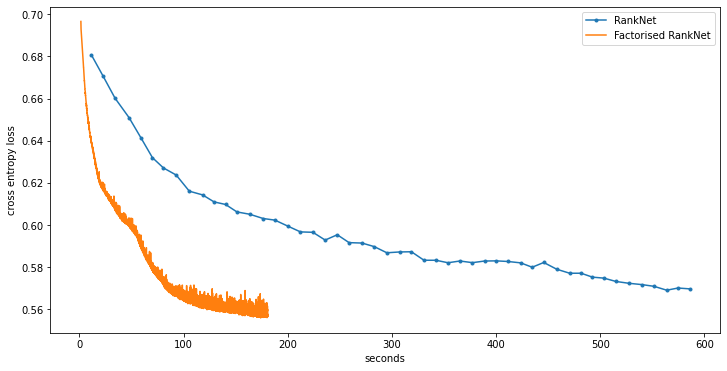

In [25]:
key = 50
x = np.cumsum(epoch_time_ranknet[key])
y = epoch_loss_ranknet[key]['testloss']

x_fac = np.cumsum(epoch_time_facranknet[key])
y_fac = epoch_loss_facranknet[key]['testloss']

plt.figure(figsize=(12,6))
plt.plot(x, y, marker='.', label="RankNet")
plt.plot(x_fac, y_fac, label="Factorised RankNet")
plt.ylabel('cross entropy loss')
plt.xlabel('seconds')
plt.legend()
plt.show()